# Importing libraries and dataset

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

data = pd.read_csv('heart.csv')#,header=None)

## Functions

In [42]:
def hist_variables(df, numeric_variables):
    df[numeric_variables].hist(bins=25, figsize=(10, 8), layout=(-1, 3), edgecolor="black")
    plt.tight_layout()

In [43]:
def replace_outliers_with_limits(column, lower_bound, upper_bound):
    new_column = column.copy()
    # Substitui valores abaixo do limite inferior pelo limite inferior
    new_column = new_column.apply(lambda x: lower_bound if x < lower_bound else x)

    # Substitui valores acima do limite superior pelo limite superior
    new_column = new_column.apply(lambda x: upper_bound if x > upper_bound else x)
    return new_column

def outliers_iqr(column, lower_quantile, upper_quantile, multiplier):
    Q1 = column.quantile(lower_quantile)
    Q3 = column.quantile(upper_quantile)
    IQR = Q3 - Q1

    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)

    return lower_bound, upper_bound

def replace_outliers_iqr(X_train, X_test, columns, lower_quantile = 0.25, upper_quantile = 0.75, multiplier = 1.5):
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    for column in columns:
        print(f"Processing column {column}")
        lower_bound, upper_bound = outliers_iqr(X_train[column], lower_quantile, upper_quantile, multiplier)

        X_train_out[column] = replace_outliers_with_limits(X_train[column], lower_bound, upper_bound)
        X_test_out[column] = replace_outliers_with_limits(X_test[column], lower_bound, upper_bound)

    return X_train_out, X_test_out

# Explorative Data Analysis

In [44]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [45]:
data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [46]:
data.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [47]:
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [48]:
data.duplicated().sum()

1

In [49]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

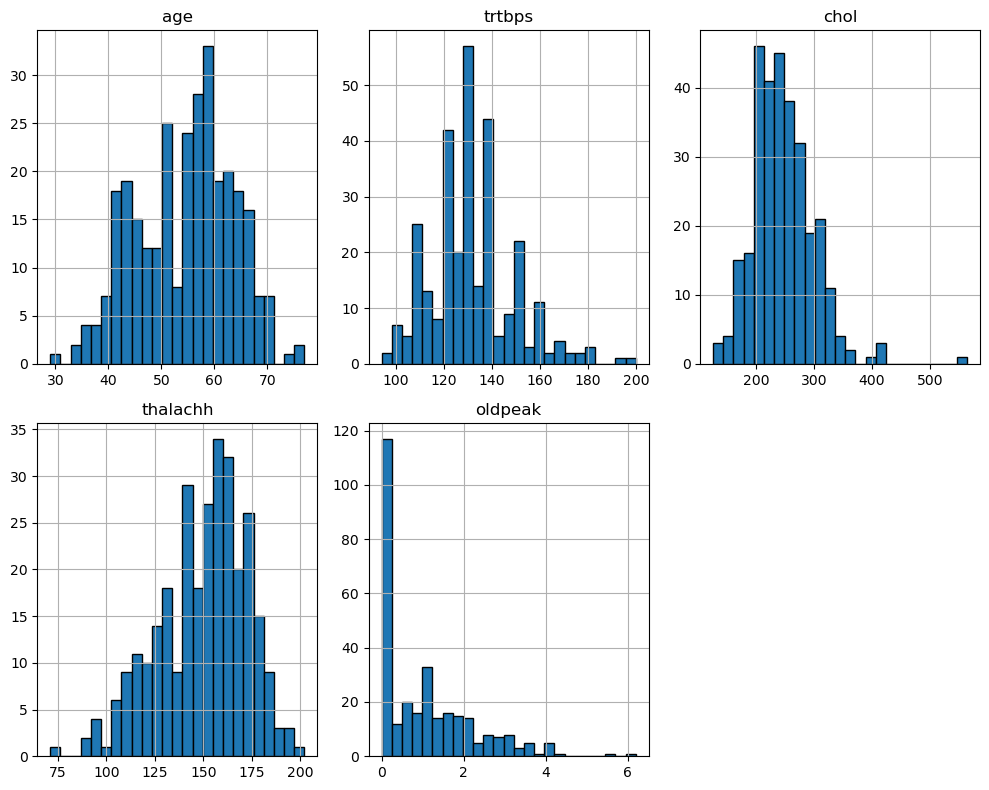

In [50]:
# Histogram of numeric variables
numeric_variables = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
hist_variables(data, numeric_variables)

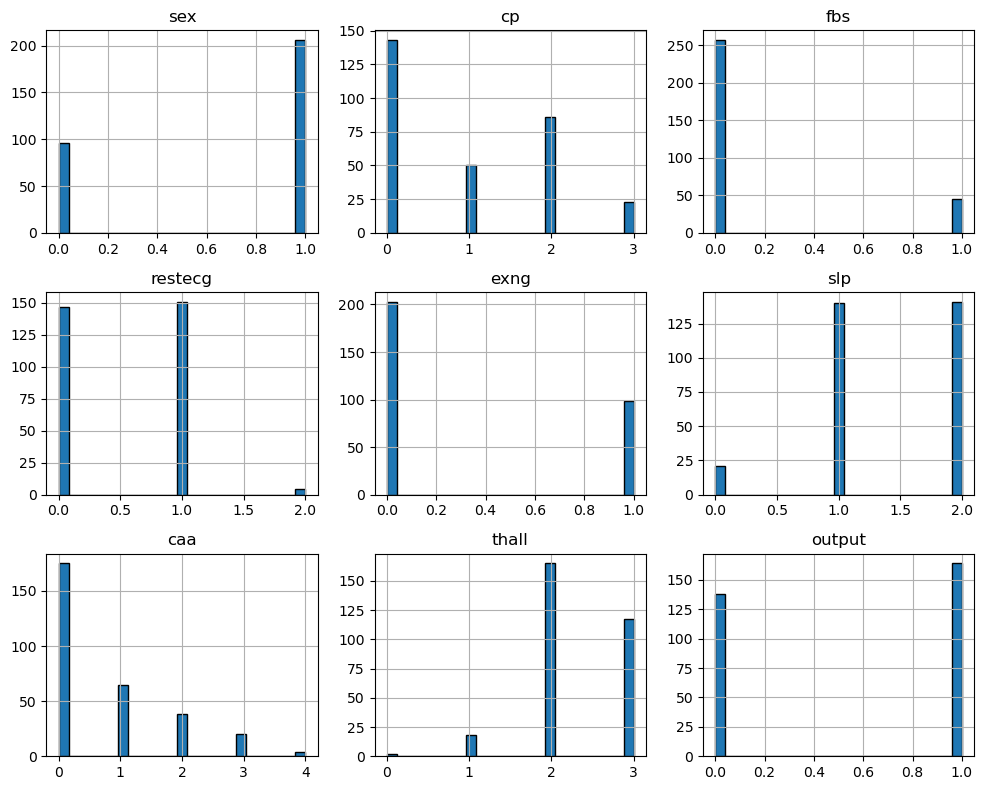

In [51]:
# Histogram of categorical variables

categorical_variables = [i for i in data.columns if i not in numeric_variables]
hist_variables(data, categorical_variables)

# Feature Engineering

## Train-Test Split

In [55]:
X = data.drop('output', axis=1)
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((220, 13), (56, 13), (220,), (56,))

## Target Balance

In [59]:
(y_train == 0).sum(), (y_train == 1).sum()

# Seeing as though there isn't  much of a diference and we have a small dataset,
# we will leave it as is

(108, 112)

## Outliers

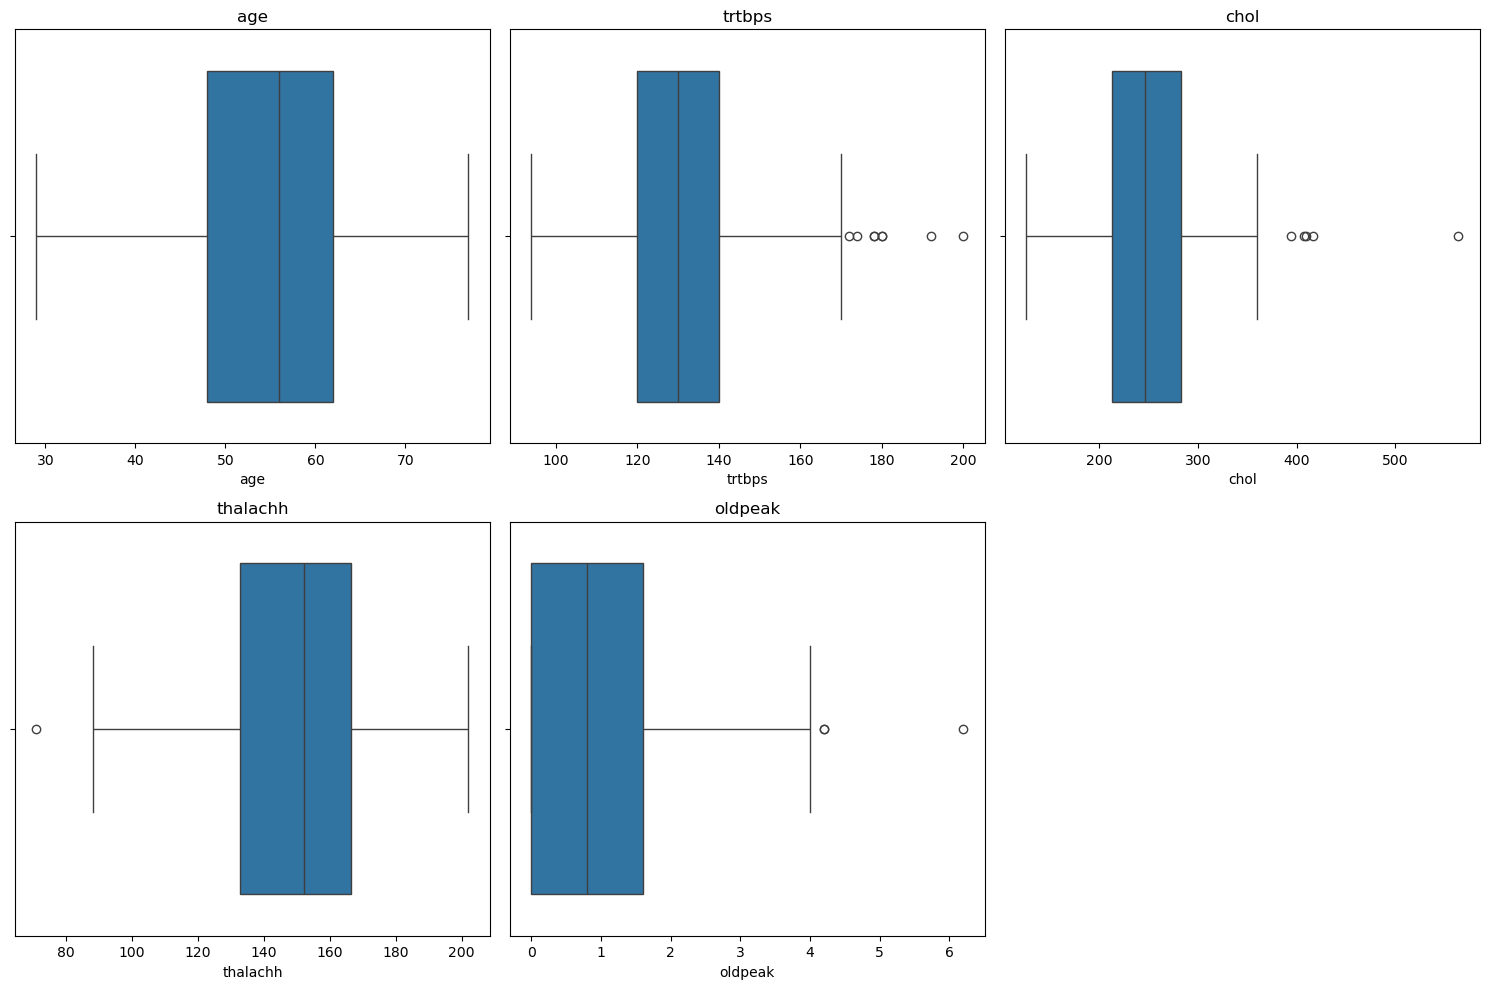

In [56]:
num_cols = len(numeric_variables)

num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # 3 plots por linha

plt.figure(figsize=(15, num_rows * 5))

for i, col in enumerate(numeric_variables):
    plt.subplot(num_rows, 3, i + 1)  # 3 colunas
    sns.boxplot(x=X_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [57]:
X_train, X_test = replace_outliers_iqr(X_train, X_test, numeric_variables, lower_quantile = 0.25, upper_quantile = 0.75, multiplier = 1.5)

Processing column age
Processing column trtbps
Processing column chol
Processing column thalachh
Processing column oldpeak


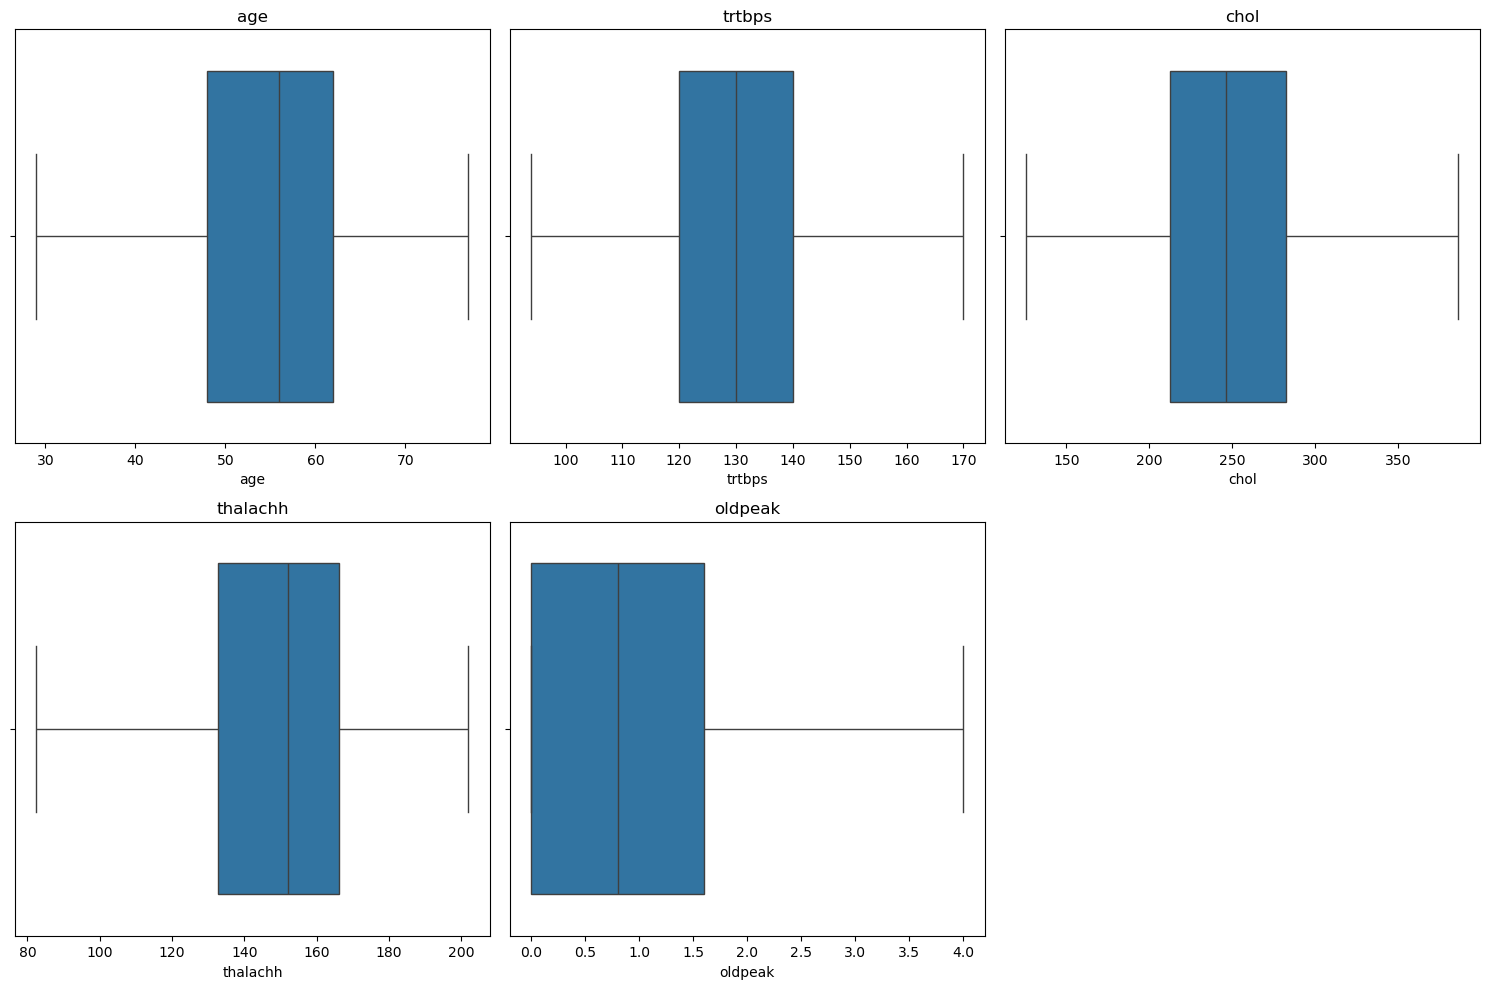

In [58]:
num_cols = len(numeric_variables)

num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # 3 plots por linha

plt.figure(figsize=(15, num_rows * 5))

for i, col in enumerate(numeric_variables):
    plt.subplot(num_rows, 3, i + 1)  # 3 colunas
    sns.boxplot(x=X_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## Scaling/Transformations

## Encoding

# Feature Selection

# Coisas a considerar

Na analise dos resultados, não esquecer que neste contexto, a sensibility (ou recall) são importantes (queremos reduzir os falsos negativos ao máximo)

Poucos dados -> considerar k-fold cv

Neural nets precisam de val set